In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
g = torch.Generator().manual_seed(2147483647)
# n_embd = 20 # Param of C
# n_hidden = 200 # Columns in W
block_size = 3
vocab_size = 27

In [7]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars) }
s2i['.'] = 0 # special for Start or End
i2s = {i:s for s,i in s2i.items()}

In [9]:
def build_ds(words):
     # how many chars do we take to predict the next one
    xs, ys = [], [] # xs are 3 leading chars, ys is the 4th char
    # eg for emma -> first xs is 000 and first ys is e
    # second xs is ..e ys is m
    # etc
    for w in words:
        
        context = [0]*block_size # 0 marks beginning/no letter from front
        for ch in w+'.': # eg emma.
            ix = s2i[ch]
            (xs.append(context), ys.append(ix))
            # print(''.join(i2s[i] for i in context), ' ---> ', ch)
            context = context[1:] + [ix] # note this context doesn't become part of the training set, because it is like ma. -> and always leads to .
     # X is say 32 x 3       
    return torch.tensor(xs), torch.tensor(ys) 

# shuffle and define training/dev/eval sets
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_ds(words[:n1])
Xdev, Ydev = build_ds(words[n1:n2])
Xte, Yte = build_ds(words[n2:])

In [10]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    # .item() converts single element array to scalar
    print(''.join(i2s[ix.item()] for ix in x), '-->', i2s[y.item()])

... --> e
..e --> b
.eb --> r
ebr --> i
bri --> m
rim --> a
ima --> .
... --> h
..h --> i
.hi --> l
hil --> t
ilt --> o
lto --> n
ton --> .
... --> j
..j --> h
.jh --> e
jhe --> n
hen --> e
ene --> .


In [11]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    """
    x is 32x100 (output of Linear layer)
    """
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean - across axis 0(rows), shape is 1x100
      xvar = x.var(0, keepdim=True) # batch variance - across axis 0
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        # Exponential Moving Average
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors С - batch size?
n_hidden = 100 # the number of neurons in the hidden layer of the MLP - columns of W
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # this is to fight tanh's squashing . Otherwise weights would ALL GO TO 0. Set to 1 if only Linear layers

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [12]:
# same optimization as last time
max_steps = 20_000#200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph - this is for plotting
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  20000: 3.3313
  10000/  20000: 2.2837


In [ ]:
torch.tensor(lossi).view(-1,1000).shape

layer 2 (      Tanh): mean -0.01, std 0.64, saturated: 7.25%
layer 5 (      Tanh): mean -0.01, std 0.69, saturated: 8.62%
layer 8 (      Tanh): mean -0.00, std 0.70, saturated: 7.81%
layer 11 (      Tanh): mean +0.01, std 0.71, saturated: 6.69%
layer 14 (      Tanh): mean -0.02, std 0.72, saturated: 5.66%


Text(0.5, 1.0, 'activation distribution')

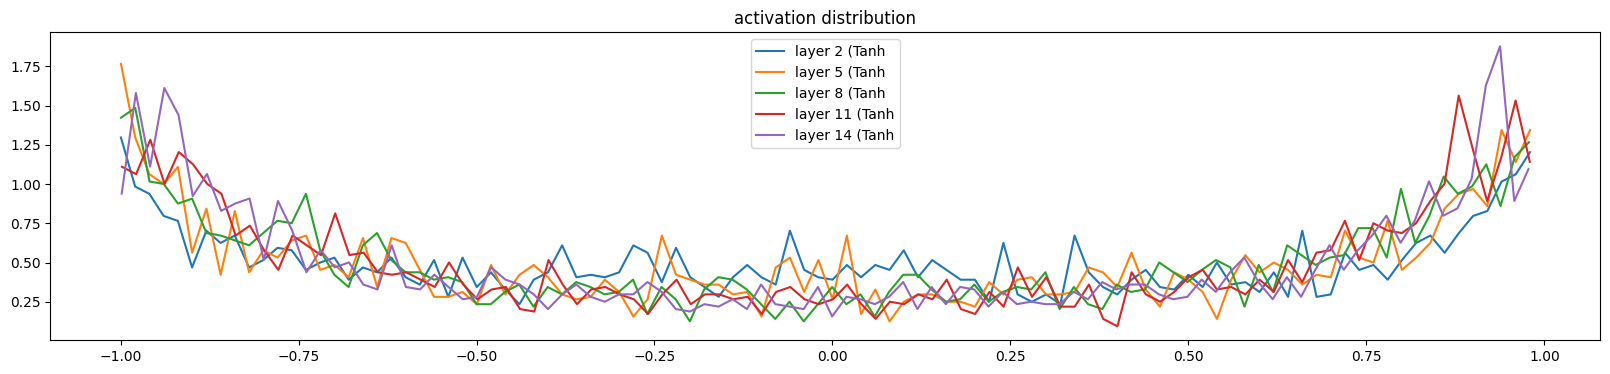

In [30]:
# visualize histograms -  you want to be STABLE, and have some std - so a line is good
# if std --> 0, that means your weights are identical (ie same number in the tensor)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

2

layer 2 (      Tanh): mean -0.000000, std 3.233143e-03
layer 5 (      Tanh): mean -0.000000, std 3.064847e-03
layer 8 (      Tanh): mean +0.000000, std 3.083902e-03
layer 11 (      Tanh): mean -0.000000, std 3.039404e-03
layer 14 (      Tanh): mean -0.000000, std 3.212891e-03


Text(0.5, 1.0, 'gradient distribution')

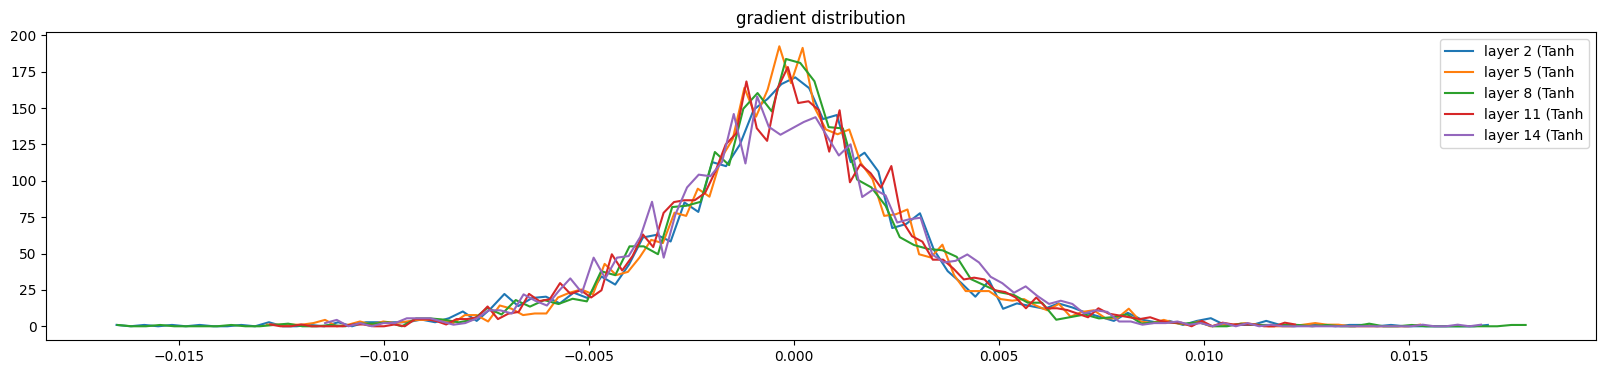

In [34]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.274368e-02 | grad:data ratio 1.248951e-02
weight  (30, 100) | mean +0.000029 | std 7.786609e-03 | grad:data ratio 2.271389e-02
weight (100, 100) | mean +0.000048 | std 5.163592e-03 | grad:data ratio 2.620369e-02
weight (100, 100) | mean +0.000013 | std 4.842958e-03 | grad:data ratio 2.489667e-02
weight (100, 100) | mean +0.000050 | std 4.856288e-03 | grad:data ratio 2.532366e-02
weight (100, 100) | mean +0.000017 | std 4.537649e-03 | grad:data ratio 2.400530e-02
weight  (100, 27) | mean -0.000032 | std 7.902810e-03 | grad:data ratio 3.355981e-02


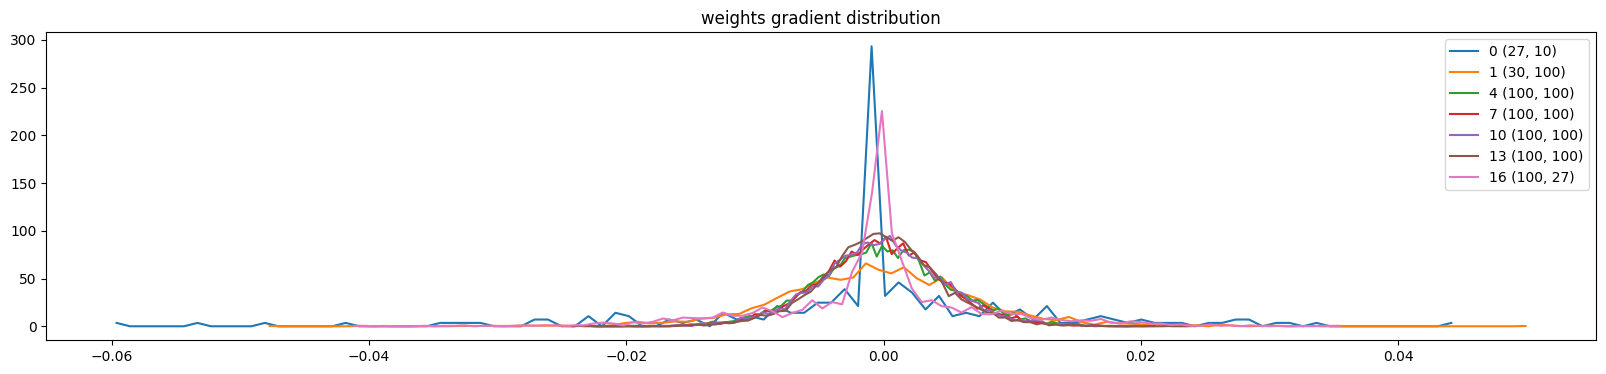

In [35]:
# if Grad is alot more volatile than weights - its a problem. Why?
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: #this is only weights, no gammas, biases etc
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

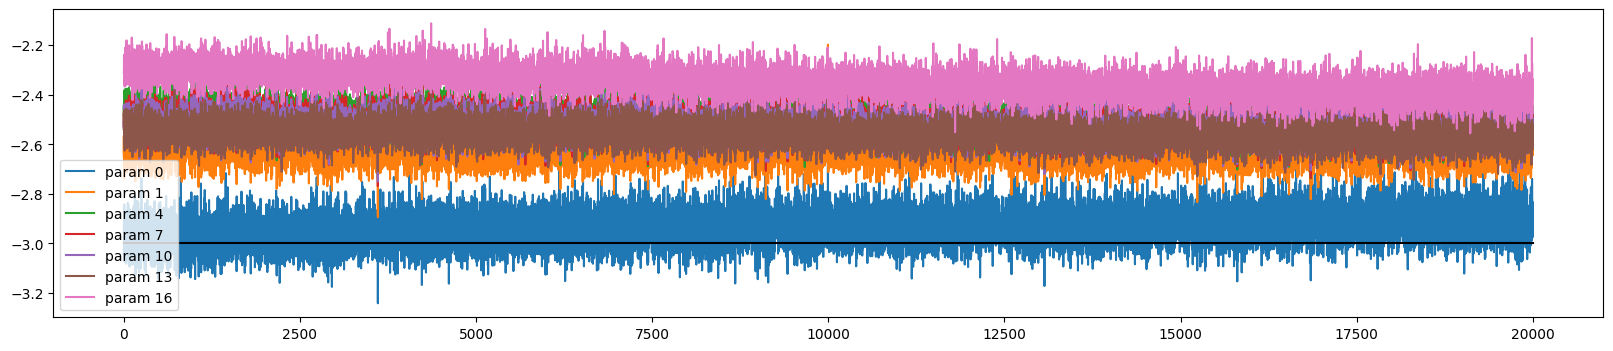

In [46]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: #just weights
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [47]:
torch.cuda.is_available()

False